# 1. Upload Datset and setup the environment
Setup Python Environment

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-rc1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0)
ERROR: No matching distribution found for tensorflow==2.0.0-rc1


Import Tensorflow and other libraries

In [ ]:
import os
from google.colab import drive
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

The data is stored in Google drive in a folder called data. The folder is called in this collab notebook. 

In [ ]:
drive.mount('/gdrive/')
!ls /gdrive
file_path = '/gdrive/My Drive/Colab Notebooks/data/'
os.chdir(file_path)

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
MyDrive  Shareddrives


# 2. Train Neural Network

## Parse and Prepare Data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

In [ ]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of activities that data is available for
ACTIVITIES = [
    "ascending_stairs_full",
    "dancing_full",
    "descending_stairs_full",
    "jumping_full",
    "sitting_full",
    "standing_full",
    "walking_full",
]

SAMPLES_PER_ACTIVITY = 240

NUM_ACTIVITIES = len(ACTIVITIES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_ACTIVITIES = np.eye(NUM_ACTIVITIES)

inputs = []
outputs = []

# read each csv file and push an input and output
for activity_index in range(NUM_ACTIVITIES):
  activity = ACTIVITIES[activity_index]
  print(f"Processing index {activity_index} for gesture '{activity}'.")
  
  output = ONE_HOT_ENCODED_ACTIVITIES[activity_index]
  
  df = pd.read_csv(activity + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_ACTIVITY)
  
  print(f"\tThere are {num_recordings} recordings of the {activity} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_ACTIVITY):
      index = i * SAMPLES_PER_ACTIVITY + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.0

Processing index 0 for gesture 'ascending_stairs_full'.
	There are 1321 recordings of the ascending_stairs_full gesture.
Processing index 1 for gesture 'dancing_full'.
	There are 1354 recordings of the dancing_full gesture.
Processing index 2 for gesture 'descending_stairs_full'.
	There are 1323 recordings of the descending_stairs_full gesture.
Processing index 3 for gesture 'jumping_full'.
	There are 1324 recordings of the jumping_full gesture.
Processing index 4 for gesture 'sitting_full'.
	There are 1276 recordings of the sitting_full gesture.
Processing index 5 for gesture 'standing_full'.
	There are 1330 recordings of the standing_full gesture.
Processing index 6 for gesture 'walking_full'.
	There are 1329 recordings of the walking_full gesture.
Data set parsing and preparation complete.


## Randomize and Split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.
The training set is used to train the model
the validation set is used to measure how well the model is performing during training.
The testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [ ]:
inputs.shape

(9257, 1440)

# 3. Build and Train the Model

A Sequential Model with 3 layers was built and trained here. The details about the model can be found in the code below. 

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_ACTIVITIES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=120, batch_size=32, validation_data=(inputs_validate, outputs_validate))


Epoch 1/120
174/174 [==============================] - 2s 7ms/step - loss: 0.1229 - mae: 0.2449 - val_loss: 0.1225 - val_mae: 0.2449
Epoch 2/120
174/174 [==============================] - 1s 4ms/step - loss: 0.1224 - mae: 0.2447 - val_loss: 0.1221 - val_mae: 0.2443
Epoch 3/120
174/174 [==============================] - 1s 4ms/step - loss: 0.1207 - mae: 0.2424 - val_loss: 0.1185 - val_mae: 0.2398
Epoch 4/120
174/174 [==============================] - 1s 4ms/step - loss: 0.1170 - mae: 0.2357 - val_loss: 0.1198 - val_mae: 0.2402
Epoch 5/120
174/174 [==============================] - 1s 4ms/step - loss: 0.1150 - mae: 0.2312 - val_loss: 0.1147 - val_mae: 0.2311
Epoch 6/120
174/174 [==============================] - 1s 4ms/step - loss: 0.1140 - mae: 0.2287 - val_loss: 0.1180 - val_mae: 0.2369
Epoch 7/120
174/174 [==============================] - 1s 4ms/step - loss: 0.1136 - mae: 0.2275 - val_loss: 0.1135 - val_mae: 0.2284
Epoch 8/120
174/174 [==============================] - 1s 4ms/step - 

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                72050     
                                                                 
 dense_13 (Dense)            (None, 15)                765       
                                                                 
 dense_14 (Dense)            (None, 15)                240       
                                                                 
 dense_15 (Dense)            (None, 7)                 112       
                                                                 
Total params: 73,167
Trainable params: 73,167
Non-trainable params: 0
_________________________________________________________________


# 4. Graph the Loss

As the graph shows, the training loss and validation loss have reduced as we trained the model with the given dataset. 

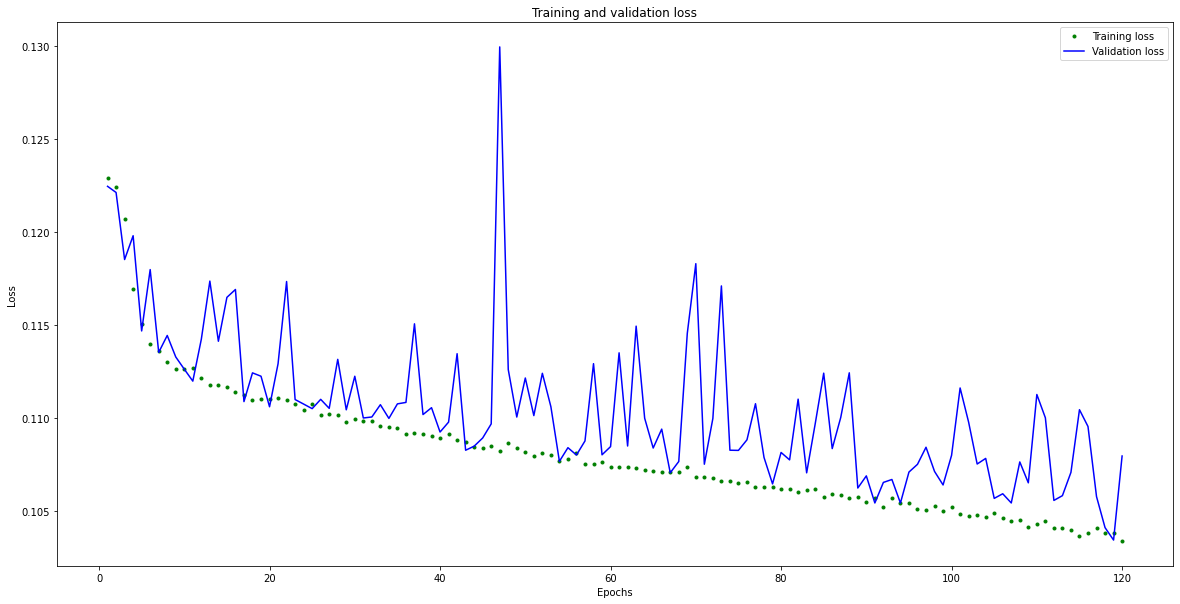

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

# 5. Graph the loss again, skipping a bit of the start

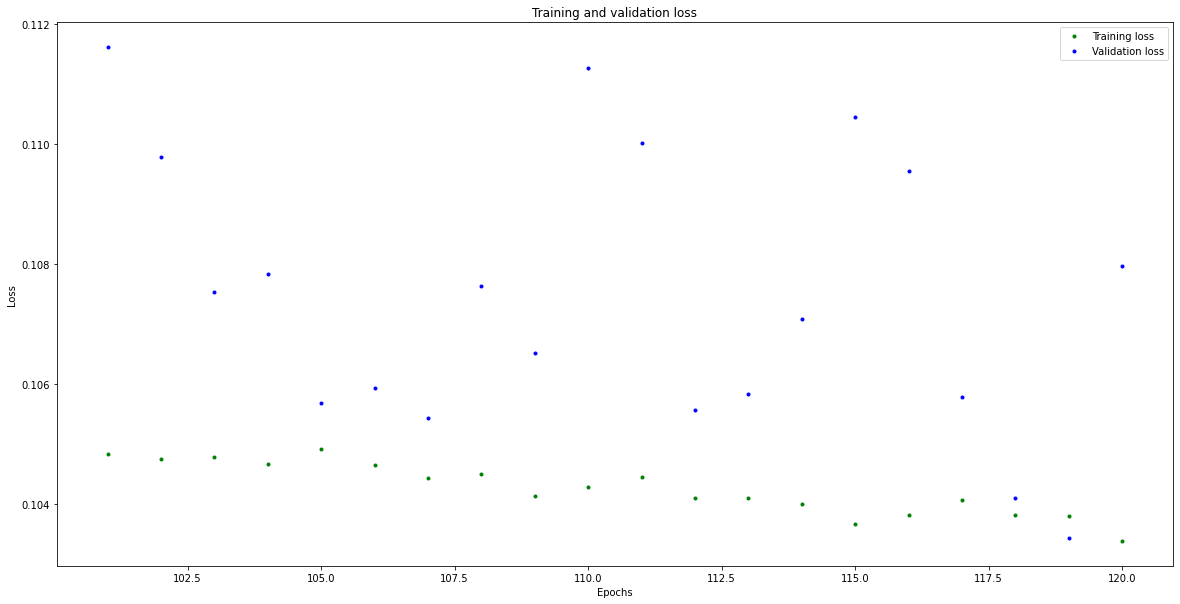

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Graph the mean absolute error

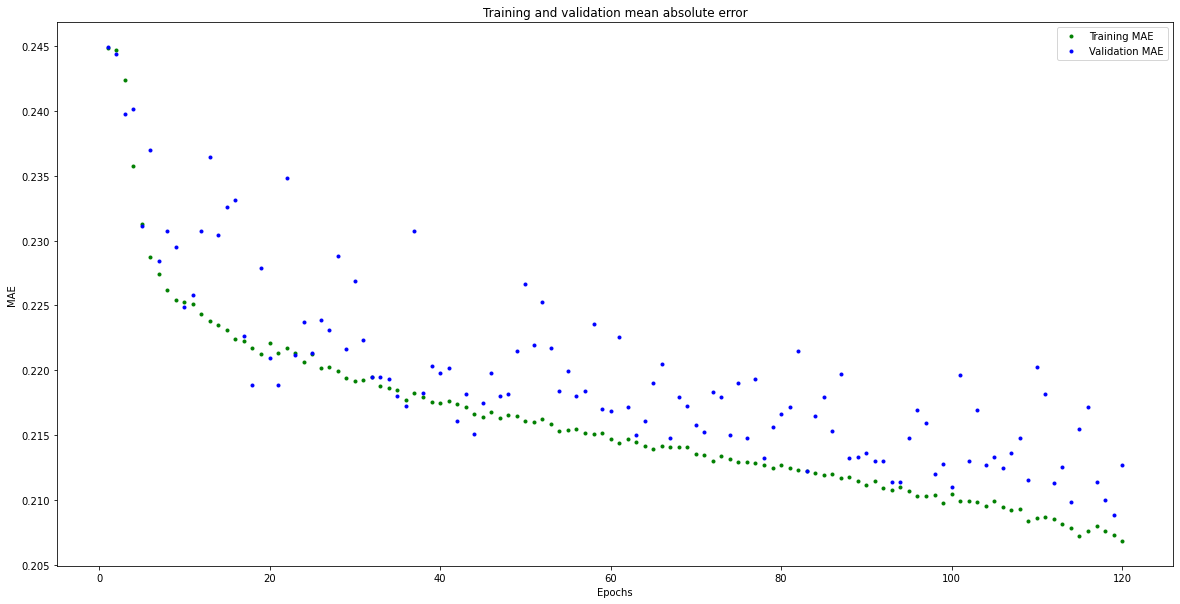

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs, mae, 'g.', label='Training MAE')
plt.plot(epochs, val_mae, 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# 7. Run with Test Data

predictions =
 [[0.014 0.02  0.007 ... 0.741 0.146 0.001]
 [0.105 0.258 0.133 ... 0.    0.142 0.052]
 [0.14  0.222 0.195 ... 0.    0.088 0.075]
 ...
 [0.187 0.172 0.228 ... 0.    0.088 0.203]
 [0.193 0.104 0.252 ... 0.    0.188 0.159]
 [0.154 0.158 0.12  ... 0.031 0.214 0.126]]
actual =
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  del sys.path[0]


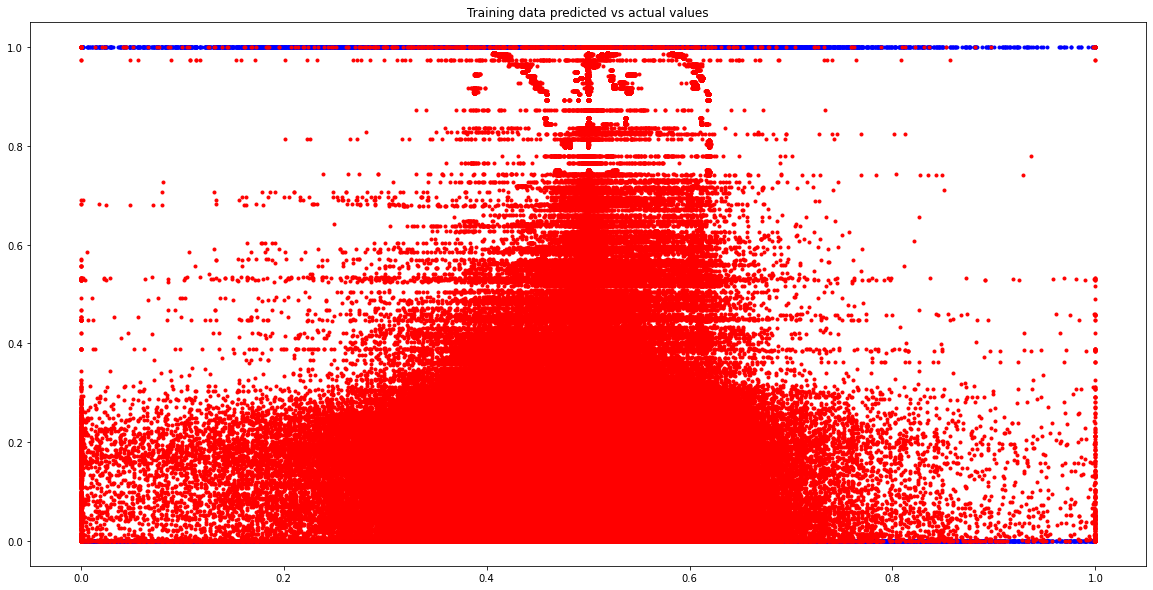

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)
#print(model.confusion_matrix)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# 8. Convert the Trained Model to Tensor Flow Lite

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)


# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
def representative_dataset_generator():
 for value in inputs_test:
 # Each scalar value must be inside of a 2D array that is wrapped in a list
  yield [np.array(value, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()
open("quantized.tflite", "wb").write(tflite_model)


import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
basic_model_size = os.path.getsize("quantized.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp6rn5n1_k/assets


INFO:tensorflow:Assets written to: /tmp/tmp6rn5n1_k/assets


INFO:tensorflow:Assets written to: /tmp/tmp1dz265li/assets


INFO:tensorflow:Assets written to: /tmp/tmp1dz265li/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model is 294924 bytes
Model is 76488 bytes


# 9. Encode the Model in an Arduino Header File

In [ ]:
!echo "const unsigned char model[] = {" >model.h
!cat gesture_model.tflite | xxd -i      >> model.h
!echo "};"                              >> model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,818,732 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
!echo "const unsigned char model[] = {" >model1.h
!cat quantized.tflite | xxd -i      >> model1.h
!echo "};"                              >> model1.h

import os
model_h_size = os.path.getsize("model1.h")
print(f"Header file, model1.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model1.h, is 471,710 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
